In [1]:
import numpy as np
import pandas as pd
import random

#import pytest
#import numpy.testing as npt

import pynsitu as pyn


## -------------- method building used for testing

# default timeseries
tdefault = dict(start="01-01-2018", end="15-01-2018", freq="1H")

In [2]:
def generate_trajectory_data_periodic(
    kind="pd_dataframe", time_units="datetime", uniform=True
):
    """Create a trajectory time series with looping."""

    time = pd.date_range(**tdefault)
    time_scale = pd.Timedelta("1D")
    if time_units == "timedelta":
        time = time - time[0]
    elif time_units == "numeric":
        time = (time - time[0]) / pd.Timedelta("1H")
        time_scale = 1.0
    if not uniform:
        nt = time.size
        time = time[random.sample(range(nt), 2 * nt // 3)].sort_values()

    v = 0.1  # m/s approx
    scale = 111e3
    lon = v * np.cos(2 * np.pi * ((time - time[0]) / time_scale)) / scale
    lat = v * np.sin(2 * np.pi * ((time - time[0]) / time_scale)) / scale
    df = pd.DataFrame(dict(lon=lon, lat=lat, time=time))
    df["id"] = "myid"
    df = df.set_index("time")

    if kind == "pd_dataframe":
        return df
    elif kind == "xr_dataset":
        ds = df.to_xarray().expand_dims(x=range(10))
        return ds
    elif kind == "xr_dask":
        ds = df.to_xarray().expand_dims(x=range(10))
        ds = ds.chunk(dict(x=2))
        return ds

df = generate_trajectory_data_periodic()

df.index.size # 337
df = df.iloc[:-1]
df.index.size # 337

336

In [3]:
dkwargs = dict(centered=True, names=("vex", "vny", "vxy"), inplace=True)

# base case: centered finite difference, geoid calculation
df.geo.compute_velocities(**dkwargs)
df["time_seconds"] = (df.index - df.index[0])/pd.Timedelta("1s")

In [4]:
df["x"] = df["x"] + 0.1*df["time_seconds"]

<Axes: xlabel='time'>

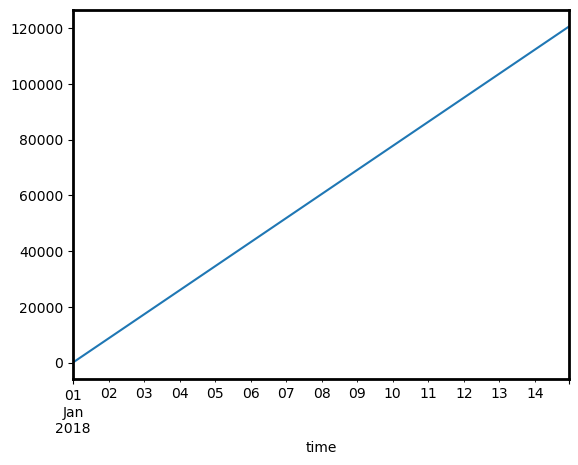

In [5]:
df["x"].plot()

In [9]:
df_bis = df.geo.compute_velocities(distance='xy',names=("vex", "vny", "vxy"))
df_sp = df.geo.compute_velocities(distance='spectral', names=("vex", "vny", "vxy"))

<Axes: xlabel='time'>

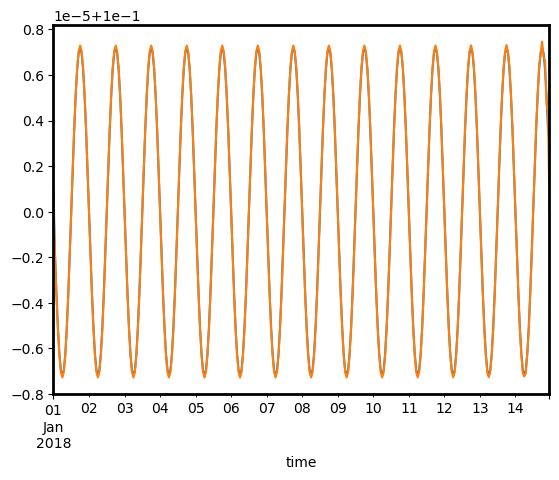

In [10]:
#df["vex"].plot()
df_bis["vex"].plot()
df_sp["vex"].plot()

<Axes: xlabel='time'>

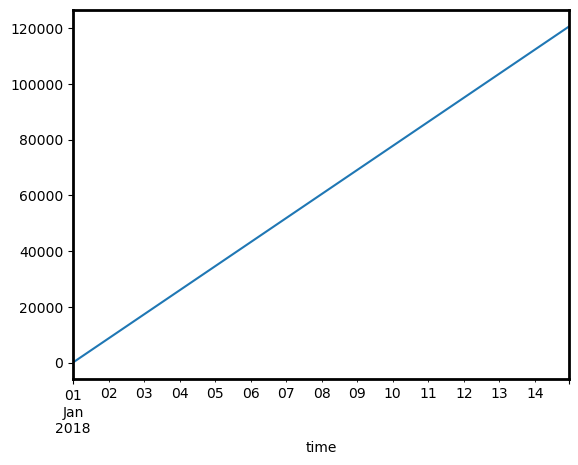

In [29]:
df.x.plot()

In [31]:
import scipy.signal as signal

In [33]:
df["x_trend"] = signal.detrend(df.x)

<Axes: xlabel='time'>

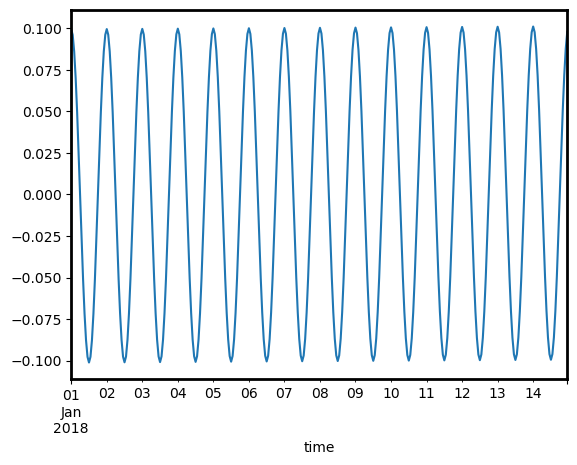

In [35]:
df["x_trend"].plot()

In [7]:
df.geo.compute_velocities?

Signature:
df.geo.compute_velocities(
    time='index',
    distance='geoid',
    centered=True,
    keep_dt=False,
    fill_startend=True,
    names=None,
    inplace=False,
)
Docstring:
compute velocity
Parameters
----------
time: str, optional
    Column name. Default is "index", i.e. considers the index
distance: str, optional
    Method to compute distances.
    Default is geoid ("WGS84" with pyproj).
    Uses projected fields otherwise ("x", "y")
centered: boolean, optional
    Centers velocity calculation temporally (True by default).
keep_dt: boolean, optional
    Keeps time intervals (False by default).
fill_startend : boolean, optional
    fill dataframe start and end (Nan values due to the derivation/centering method) (True by default).
names :  tuple, optional
    Contains columns names for eastern, northen and norm velocities
    ("velocity_east", "velocity_north", "velocity" by default
inplace : boolean, optional
    if True add velocities to dataset, if False return only

In [ ]:

@pytest.fixture()
def sample_trajectory_data_steady():
    """Create a trajectory time series with a steady flow."""
    freq = "1H"
    time = pd.date_range(start="2018-01-01", end="2018-01-15", freq=freq)

    ve, vn = 0.1, 0.1

    df = pd.DataFrame(dict(time=time))
    df = df.set_index("time")

    df["ve"] = ve
    df["vn"] = vn

    dt = pd.Timedelta(freq) / pd.Timedelta("1s")
    df["x"] = df["ve"].cumsum() * dt
    df["y"] = df["vn"].cumsum() * dt

    lon0, lat0 = 0, 45
    proj = pyn.geo.projection(lon0, lat0)
    df["lon"], df["lat"] = proj.xy2lonlat(df["x"], df["y"])

    return df


def test_compute_velocities(sample_trajectory_data_steady):

    df = sample_trajectory_data_steady
    dkwargs = dict(centered=True, names=("vex", "vny", "vxy"), inplace=True)

    # base case: centered finite difference, geoid calculation
    df.geo.compute_velocities(**dkwargs)
    npt.assert_allclose(df["ve"], df["vex"], rtol=5e-2)
    npt.assert_allclose(df["vn"], df["vny"], rtol=5e-2)

    # from spectral calculation
    kwargs = dict(**dkwargs)
    kwargs["distance"] = "spectral"
    df.geo.compute_velocities(**kwargs)

    # from projected fields x/y
    kwargs = dict(**dkwargs)
    kwargs["distance"] = "xy"
    df.geo.compute_velocities(**kwargs)


def test_compute_acceleration(sample_trajectory_data_steady):

    # from velocities
    # to do ...
    # df = sample_trajectory_data_steady.copy()

    # from xy
    df = sample_trajectory_data_steady.copy()
    df.geo.compute_accelerations(
        from_=("xy", "x", "y"), names=("aex", "any", "axy"), inplace=True
    )

    npt.assert_allclose(df["aex"], df["aex"] * 0, atol=1e-10)
    npt.assert_allclose(df["any"], df["aex"] * 0, atol=1e-10)
    npt.assert_allclose(df["axy"], df["aex"] * 0, atol=1e-10)
